### Towards grapher 0.3

#### Sample bd CPS line plot with two lines

January 15, 2019

Brian Dew, brian.w.dew@gmail.com

-----
The goal here is to eventually parameterize this script and integrate it with the bd_CPS_grapher.ipynb file.

To Do:

Refactor the extremely long code that is used to space the end point labels.

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import timedelta

os.chdir('/home/brian/Documents/CPS/data/clean')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)
plt.rcParams.update({'axes.titlesize': 'x-large'})

# Recession start and end months, from NBER
rec_dt = [('1990-08-01', '1991-04-01'), 
          ('2001-04-01', '2001-12-01'), 
          ('2008-01-01', '2009-07-01')]

In [2]:
keep_cols = ['MONTH', 'LFS', 'BASICWGT', 'AGE', 'STATE']
state1 = ['KY', 'TN']
state2 = ['OH', 'IN']
calcs = [('Kentucky and\nTennessee', '25 <= AGE <= 54 and STATE in @state1'),
         ('Ohio and\nIndiana', '25 <= AGE <= 54 and STATE in @state2')]

In [3]:
emp = lambda x: np.where(x['LFS'] == 'Employed', 1, 0)
wm = lambda x: np.average(x, weights=df.loc[x.index, 'BASICWGT']) * 100
mask = ' or '.join([f'({c[1]})' for c in calcs])
grouper = lambda x: pd.Categorical(
    np.where(x.eval(calcs[0][1]), calcs[0][0], calcs[1][0]))

In [4]:
data = pd.DataFrame()
for year in range(1989, 2020):
    df = (pd.read_feather(f'cps{year}.ft', columns=keep_cols)
            .query(mask)
            .assign(GROUP = grouper, 
                    EMP = emp))
    result = (df.groupby(['MONTH', 'GROUP'])
                .agg({'EMP': wm})).unstack()['EMP']
    result.index = pd.to_datetime([f'{year}-{i}-01' for i in result.index])
    data = data.append(result)

In [5]:
# Handling possible overlap of end point labels
srs = data.rolling(12).mean().dropna()
max_gap = (data.max().max() - data.min().min()) / 10.0

end_val0 = srs.iloc[-1, 0]
label_end_val0 = srs.columns[0]
end_val1 = srs.iloc[-1, 1]
label_end_val1 = srs.columns[1]

end_date = srs.index[-1]
end_gap = abs(end_val0 - end_val1)

if end_val0 > end_val1:
    top = end_val0
    top_txt = label_end_val0
    bottom = end_val1
    bottom_txt = label_end_val1
elif end_val1 > end_val0:
    top = end_val1
    top_txt = label_end_val1
    bottom = end_val0
    bottom_txt = label_end_val0
else:
    top = end_val1
    top_txt = label_end_val1
    bottom = end_val0
    bottom_txt = label_end_val0
    print('special')
    #special case

if '\n' not in top_txt:
    max_gap = max_gap * 0.66
    
if end_gap > max_gap:
    top_spacer = max_gap
    bottom_spacer = max_gap
    date_spacer = max_gap * 1.5
else:
    top_spacer = max_gap
    bottom_spacer = 0
    date_spacer = max_gap * 1.5


top_label = f'{top_txt}:\n{round(top, 1)}%'
top_label_loc = (end_date + timedelta(days=120), top + top_spacer)
bottom_label = f'{bottom_txt}:\n{round(bottom, 1)}%'
bottom_label_loc = (end_date + timedelta(days=120), bottom + bottom_spacer)

In [6]:
colors = ['blue', 'green']

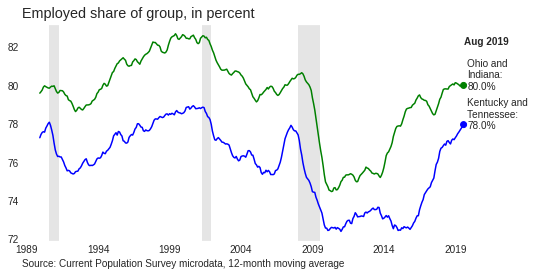

In [7]:
title = 'Employed share of group, in percent'
offset = pd.DateOffset(months=4)
plot = srs.plot(figsize=(8, 4), color=colors, legend=None)
ax = plt.xlim(data.index[0] - offset, data.index[-1] + offset)
ax = plt.title(title, loc='left')

# Recession bars
for i, v in rec_dt:
    ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.2)
    
    
ax = plt.scatter([srs.index[-1]] * 2, srs.iloc[-1].values, 
                 color=colors)


ax = plt.annotate(f'{srs.index[-1]:%b %Y}', (end_date, top + date_spacer), 
                  fontweight='bold')
ax = plt.annotate(top_label, top_label_loc, va='top')
ax = plt.annotate(bottom_label, bottom_label_loc, va='top')

ax = plt.xlabel('Source: Current Population Survey microdata, 12-month moving average', ha='left', x=0)